# Información integrantes del equipo de trabajo

**Nombre y apellidos (Grupo):**

**Nombre y apellidos (Grupo):**

**Nombre y apellidos (Grupo):**

# Random walk


## Apartado a:

- Considerar una caminata aleatoria en 1D con pasos de tamaño 1. Definid una función que tome como entrada el punto de partida y el número de pasos, $N$, a realizar en la caminata y devuelva la trayectoria completa del caminante. Definid la función de tal forma que pueda introducirse un array como punto inicial, de forma que se simulen en paralelo más de un caminante. Con esta función obtened el camino aleatorio seguido por $M=1000$ caminantes.

- Representar la posición de varios de los caminantes en función de los pasos dados (tomad $N$ del orden de 100000).


In [12]:
# Librerias
from pylab import plot, show, hist, title, xlabel, ylabel, legend, axis
from numpy import hstack, zeros, hsplit, column_stack, exp, pi, histogram, ndarray, linspace, arange, std, array
from numpy.random import randint
from scipy.optimize import curve_fit as fit

In [49]:
# Funciones

# esta función se puede reusar luego para el random walk en 2D (tal vez no pero bueno)
def randomStep(moves: ndarray, pos: int) -> ndarray:
    moves[:, pos+1] = moves[:, pos] + ((-1)**randint(0, 2, moves[:, pos].size))
    return moves

def randomWalk1D(people: int, steps: int) -> ndarray:
    moves = zeros([people, steps], int)
    for i in range(steps-1):
        moves = randomStep(moves, i)
        print(f'step: {i}/{steps}', end='\r')   # indica el progreso. TODO (MQ): usar tqdm
    print('steps completed')
    return moves

def plotWalk(moves: ndarray, people: int = 5):
    for i in range(people):
        plot(moves[i,:])
    xlabel('Pasos')
    ylabel('$x$')
    title(f'Evolución de {people} caminantes')
    show()

steps completed


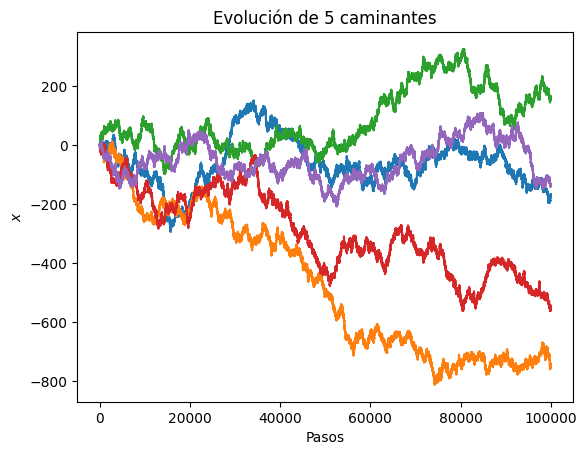

In [4]:
steps = 100000
people = 1000
moves = randomWalk1D(people, steps)
plotWalk(moves)

- A partir de los datos obtenidos, para un cierto paso (por ejemplo el paso 2000), obtened el histograma de la posición de los caminantes.
- Ajustad los datos obtenidos a una distribución gaussiana y obtened la media y la desviación estandar de la distribución.

In [5]:
def stepsGaussian(x, stdev, mean, amp):
    val = ((x-mean) / stdev)**2
    return exp(-val)*amp

def fitGaussian(moves: ndarray, step: int, bins: int = 20) -> tuple[float, float, float]:
    ydata, xdata = histogram(moves[:,step-1], bins)
    initGuess = (step**0.5, 0, 100) # muy importante para asegurar la estabilidad de la solución ajustada
    stdev, mean, amplitude = fit(stepsGaussian, xdata[0:xdata.size-1], ydata, initGuess)[0][:]
    return stdev, mean, amplitude, xdata, ydata

def histSteps(moves: ndarray, step: int, bins: int = 20):
    stdev, mean, amp, xdata, ydata = fitGaussian(moves, step, bins)
    lim = abs(xdata).max()
    x = linspace(-lim,lim,100)
    hist(moves[:,step-1], bins)
    plot(x, stepsGaussian(x, stdev, mean, amp))
    xlabel('$x$')
    ylabel('Frecuencia')
    title(f'Distribución con $\sigma =$ {round(stdev,2)}, $\mu =$ {round(mean,2)}')
    show()


steps completed


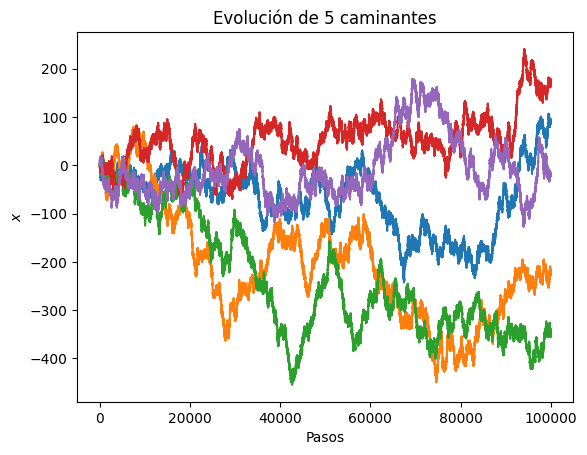

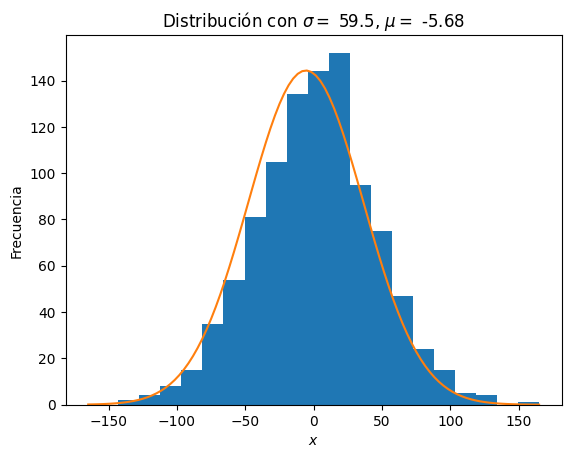

In [6]:
moves = randomWalk1D(people, steps)
plotWalk(moves)
histSteps(moves, 2000)

- Usando los datos obtenidos, obtener la desviación estandar de los datos para cada paso de tiempo, es decir, la desviación estandar como función del número de pasos.
- Realizar un ajuste de los datos a una función de la forma $f(x)=Ax^b$, y superponer el ajuste. Comprobad que se cumple que $STD(n)\simeq \sqrt{n}$, siendo $n$ el número de pasos dados.

In [7]:
def expectedStd(step, amp, expn):
    return amp*step**expn

def stepStd(moves, steps):
    stdev = []
    for i in range(steps):
        stdev.append(std(moves[:,i]))
    return stdev

def fitStd(moves, steps, plt: bool = True):
    stdev = stepStd(moves, steps)
    stepLin = arange(0,steps,1)
    initGuess = (1, 0.5)
    amp, expn = fit(expectedStd, stepLin, stdev, initGuess)[0][:]

    if plt:
        plot(stepLin, stdev, label='Experimental')
        plot(stepLin, expectedStd(stepLin, 1, 0.5), label='Teórico')
        plot(stepLin, expectedStd(stepLin, amp, expn), 'k--', label='Ajuste')
        xlabel('Pasos')
        ylabel('$\sigma$')
        title(f'Ajuste con $A =$ {round(amp,2)}, $b =$ {round(expn,2)}')
        legend()
    return amp, expn


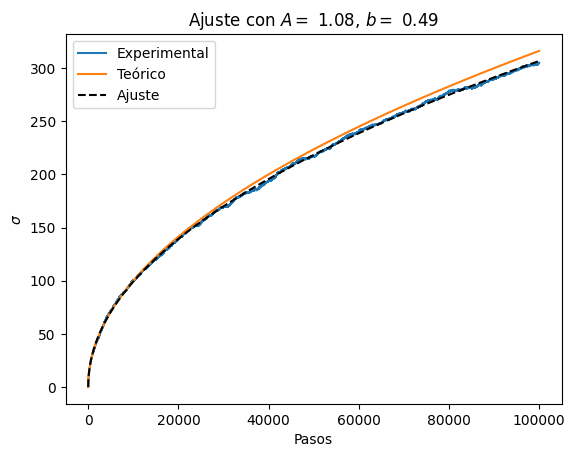

In [8]:
amp, expn = fitStd(moves, steps)

## Apartado b:

- Definir una nueva función que tome como entrada el punto inicial y el numero de pasos para una caminata aleatoria en un retículo en dos dimensiones, es decir, ahora podemos movernos una distancia 1 en la dirección $x$ o $y$. La función devolverá el recorrido de los caminantes.
- Representar para algunos caminantes las trayectorias seguidas tras dar $N=100000$ pasos

In [71]:
def randomWalk2D(x0, y0, steps) -> tuple[ndarray, ndarray]:
    x = zeros([steps], int)
    x[0] = x0
    y = zeros([steps], int)
    y[0] = y0
    for i in range(steps-1):
        if randint(0,2) == 0:
            x[i+1] = x[i] + (-1)**randint(0,2)
            y[i+1] = y[i]
        else:
            x[i+1] = x[i]
            y[i+1] = y[i] + (-1)**randint(0,2)
    return x, y

def randomWalk2DRepeat(x0, y0, steps) -> ndarray: # this is a terrible name
    people = x0.size
    # initPos = zeros([people,2], int)
    # for i in range(people):
    #     initPos[i,0] = x0[i]
    #     initPos[i,1] = y0[i]

    moves = zeros([people,2,steps])
    for i in range(people):
        x, y = randomWalk2D(x0[i], y0[i], steps)
        moves[i,0,:] = x
        moves[i,1,:] = y
        print(f'people: {i+1}/{people}', end='\r')
    return moves

def plotWalk2D(moves):
    for i in range(moves.shape[0]):
        plot(moves[i,0,:],moves[i,1,:])
    xlabel('$x$')
    ylabel('$y$')
    title(f'Evolución de {moves.shape[0]} caminantes')
    axis('equal')
    show()

def randomPosInit(people: int, lim: int) -> tuple[ndarray, ndarray]:
    x0 = randint(-lim, lim+1, people)
    y0 = randint(-lim, lim+1, people)
    return x0, y0

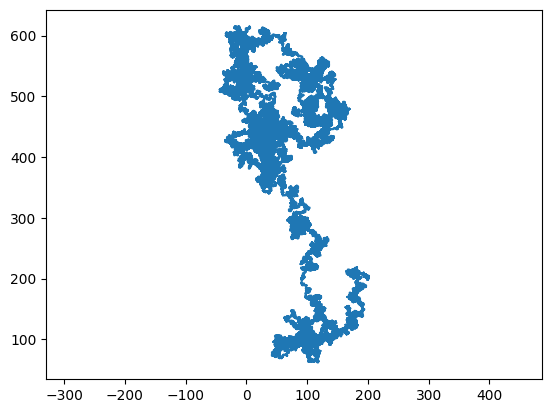

In [10]:
steps = 100000
x, y = randomWalk2D(200,200,steps)
plot(x,y)
axis('equal')
show()

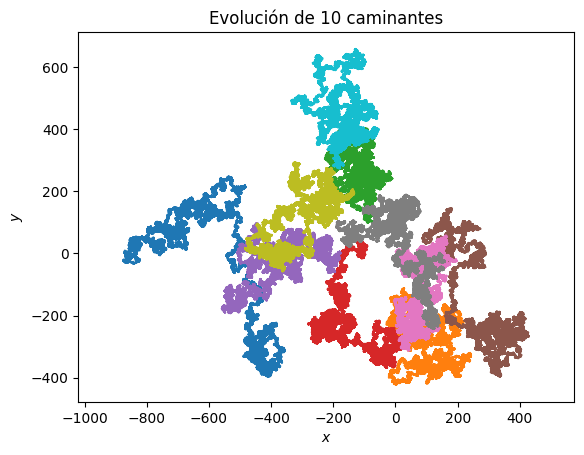

In [78]:
steps = 100000
x0, y0 = randomPosInit(10, 400)
moves = randomWalk2DRepeat(x0, y0, steps)

plotWalk2D(moves)

- Considerar un numero de pasos fijo, y obtener el histograma de la posición $x$ del caminante, y ajustar los resultados a una función gaussiana. Haced lo mismo para la posición en $y$.

**EXTRA**: obtener el histograma bidimensional de la posición, y ajustar esta función de distribución a una superficie gaussiana.

## Apartado c

- Obtener un punto del primer cuadrante del plano de forma aleatoria, por ejemplo uno dentro del cuadrado $[10,15]\times[10,15]$. Realizar una caminata de unos 10000 pasos para varias muestras y comprobad cuantas de ellas pasan por ese punto.

- Implementad una estrategia de reseteo, es decir, si después de dar $r$ pasos no hemos llegado al punto buscado volvemos a poner al paseante en el origen y continuamos hasta hacer el total de 10000 pasos. Para varios valores de $r$ obtener la fracción de paseantes que alcanzan el punto objetivo y representad los resultados. **EXTRA**: Para cada valor de $r$ repetid varias veces el experimento de simular $M$ paseantes para puntos del primer cuadrante y obtener la curva anterior con una estimación de los errores en las medidas.